> The scope of this project is to use Snorkel DryBell generative approach to produce a set of weak labels for a chosen dataset.

> The proposed dataset consists of Amazon Consumer Reviews of Amazon Products. The aim is to train a classifier over the review data that can predict whether reviews are positive, negative or neither . We have access to a large amount of unlabelled data in the form of consumer reviews of Amanzon prudcts. For training a classifier, we will label the data. However, hand-labelling tens of thousand of data points is generally slow and costly. Therefore, we will use  a weak supervision approach using labelling functions in Snorkel. This are noisy, programmatically rules and heuristics that appoint labels to unlabeled training data (Snorkel.org, 2020).

> The reviews dataset contains a ratings column for each Amazon product. The rating column rates products from 1 (really bad) to 5 (very good). As such, two labelling funtions will be created  to determine whether positive reviews  are contained in the last 3 rating tiers and negative reviews are contained in the first two rating tiers. The most common positive and negative words that were identified in the dataset will be used to determine positive vs negative reviews. These labels will be then used as a basis Descriminative model, will be trained to further enhance the model performance and will further be used to evaluate the accuracy of the combination of the models.


In [0]:
# Code here to push the Notebook to Git

We start by importing all necesssary  libraries and installing Snorkel. 

In [1]:
# Import Libraries, OS and Setup 

%matplotlib inline

from sklearn import datasets
import numpy as np
import pandas as pd

!pip install snorkel

     |████████████████████████████████| 143kB 4.9MB/s 
     |████████████████████████████████| 1.8MB 54.4MB/s 
     |████████████████████████████████| 6.7MB 39.4MB/s 
     |████████████████████████████████| 194kB 50.6MB/s 
     |████████████████████████████████| 676.9MB 26kB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=a11ce32a12068bad95adeaec0babab914d5c8afe31ad6f99db7f75171a08cd44
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation:

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis


from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [4]:
# pyspark setup

!pip install pyspark
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!cd "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"

In [0]:
import os 
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark



In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/spark-2.4.5-bin-hadoop2.7"

COLAB_NOTEBOOKS_DATA_PATH="/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"
SPARK_ARCHIVE='spark-2.4.5-bin-hadoop2.7.tgz'
if SPARK_ARCHIVE not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

SPARK_ARTIFACTS='spark-2.4.5-bin-hadoop2.7'
if SPARK_ARTIFACTS not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"


In [0]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext

In [0]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

We load the Amazon reviews dataset and develop a Pandas DataFrame and a Spark Resilient Distributed Datasets (RDD). 

In [60]:
# Load the Data

amazon_reviews_dataset_sql_context = sqlContext.read.csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",header=True)
amazon_reviews_dataset_pd_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
amazon_reviews_dataset_rdd = sc.textFile("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Show the top five rows in the DataFrame
amazon_reviews_dataset_pd_df.head(5)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


Next, for each rating tier,  we want to visualize the words that seem to appear the most. These most common words will then be used to determine whether positive reviews are contained in the last 3 rating tiers and negative reviews are contained in the first two rating tiers.  

  The first rating tier (1) is considered to be consistent of really negative reviews. The following graph, helps us understand the words that seem to appear in this specific tier. 

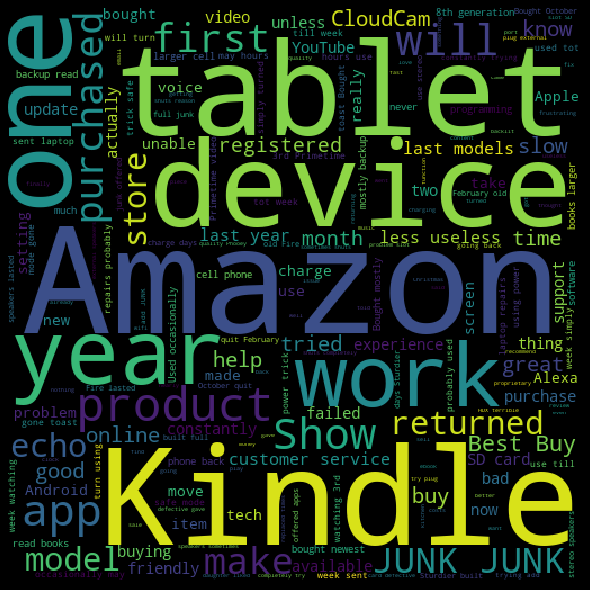

In [19]:
# Visualise the 5 different reviews WordCloud and figure other ways to quantify frequency of words
# From - https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

# WorldCloud - Review == 1 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==1]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



The second rating tier (2) is considered to be consistent of less negative reviews compared to the first tier. The following graph, helps us understand the words that seem to appear in this specific tier. 

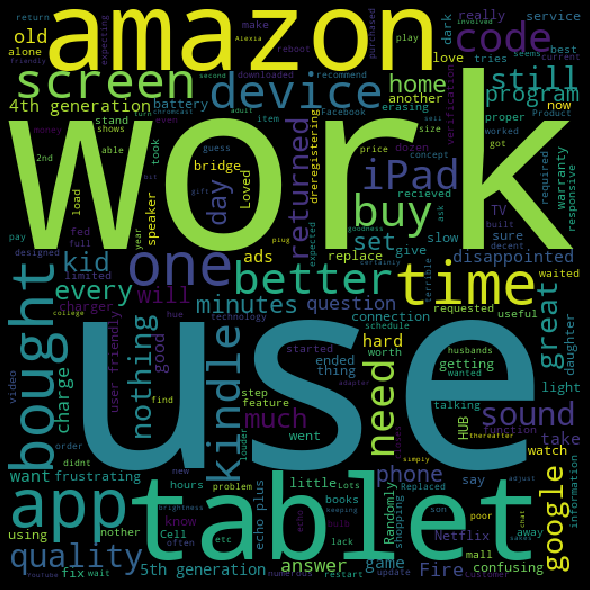

In [20]:
# WorldCloud - Review == 2 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==2]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

The third rating tier (3) is considered to be consistent of positive reviews but not that pleasing . The following graph, helps us understand the words that seem to appear in this specific tier.

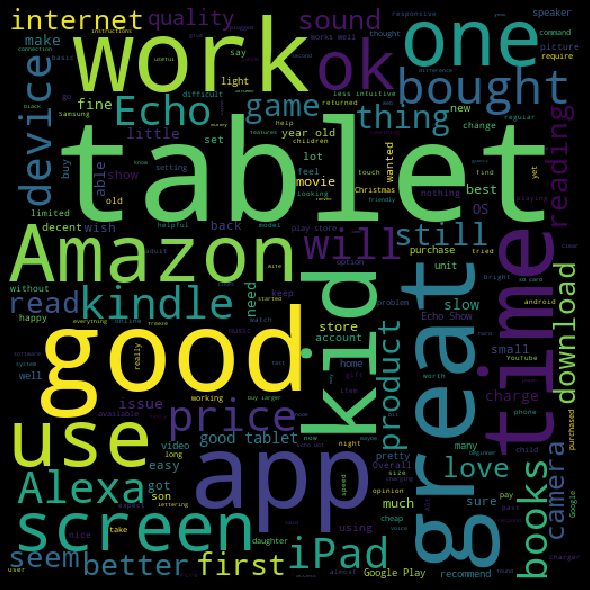

In [21]:
# WorldCloud - Review == 3 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==3]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

The fourth rating tier (4) is considered to be consistent of more positive reviews compared to the third tier. The following graph, helps us understand the words that seem to appear in this specific tier.

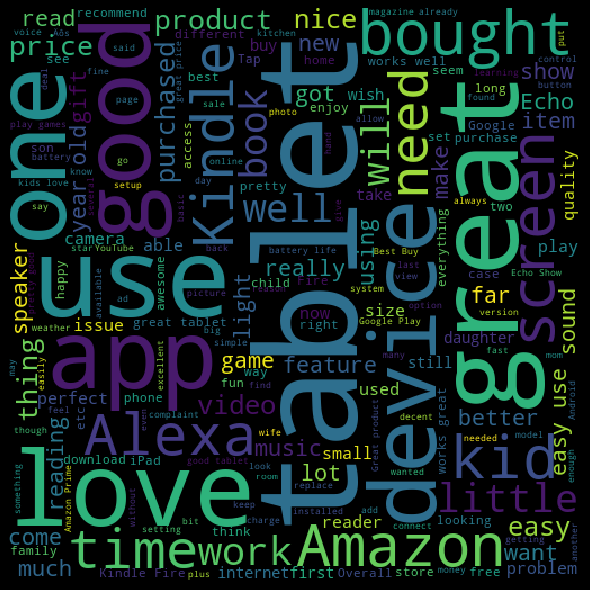

In [22]:
# WorldCloud - Review == 4 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==4]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

The fifth rating tier (5) is considered to be consistent of the most positive reviews. The following graph, helps us understand the words that seem to appear in this specific tier.

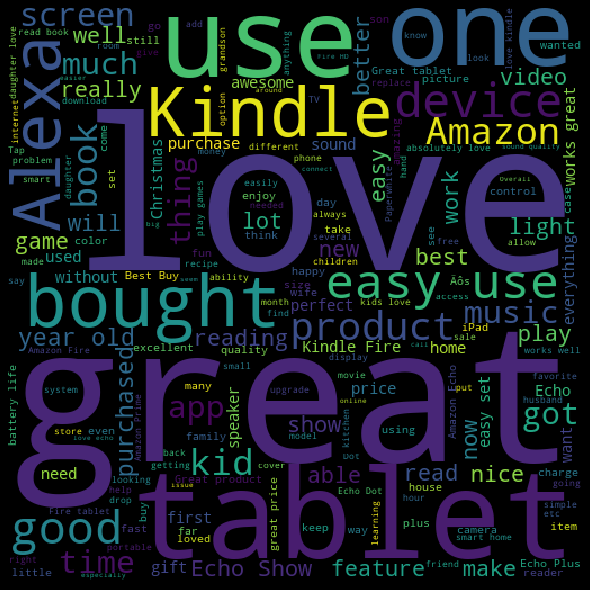

In [23]:
# WorldCloud - Review == 5
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==5]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

We define constants to represent the class labels for: 

- Rating one = 0
- Rarting two = 1 
- Rarting three = 2
- Rating four = 3
- Rating five = 4
- Abstaining: -1

In [0]:
# Set voting values.
RATINGONE = 0
RATINGTWO = 1 
RATINGTHREE = 2
RATINGFOUR = 3
RATINGFIVE = 4
ABSTAIN = -1

We will now write labelling functions to determine whether positive reviews  are contained in the last 3 rating tiers and negative reviews are contained in the first two rating tiers as expected by human intuition. 

In [0]:
from textblob import TextBlob 
from snorkel.preprocess import preprocessor

# Common posititve words 
POSITIVE = r"\bjew (love|great|good|easy|happy|nice|fun|pretty|works|better|well|ok)"
# Common negative words
NEGATIVE = r"\bjew (old|junk|useless|failded|slow|nothing)"

# labelling functions for five different rating tiers 
@labeling_function()
def positive(x):
  return RATINGTHREE, RATINGFOUR, RATINGFIVE if POSITIVE in x.text.lower() else ABSTAIN

@labeling_function()
def negative(x):
 return RATINGONE, RATINGTWO if NEGATIVE in x.text.lower() else ABSTAIN
  

To apply the created labelling functions to a collection of data points, we use an LFApplier. In this case, we use the PandasLFApplier because our data points are represented with a Pandas DataFrame.  

In [89]:
# Label matrix

from snorkel.labeling import PandasLFApplier

lfs = [positive, negative]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df = amazon_reviews_dataset_pd_df)


ImportError: ignored

We calculate the coverage of the created labelling functions,  the percentage of the dataset that they label in order to evaluate the performance of our labels. 

In [84]:
# Performance Evaluation
coverage_check_out, coverage_check = (amazon_reviews_dataset_pd_df != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

ValueError: ignored

> We will now  move forward with out analysis and start writting labelling functions that use a third-party model.

> The TextBlob tool suppliers a pretrained sentiment analyzer. The positive and negative classification tasks are not the same as sentiment classifications. We might think that rating tiers have different distributions of sentiment scores (Snorkel.org, 2020).

We start by developing a Preprocessor that runs TextBlob on our review comments and later, obtains the polarity and subjectivity scores.

In [0]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob

# extract polarity and subjectivity scores 
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

First, we focus on writing labelling functions for the last three rating tiers which are though to contain mostly positive reviews comments. 

In [0]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return RATINGTHREE, RATINGFOUR, RATINGFIVE if x.polarity > 0.9 else ABSTAIN

In [0]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return RATINGTHREE, RATINGFOUR, RATINGFIVE if x.subjectivity >= 0.5 else ABSTAIN

We now need to apply our labelling functions so we can analyze their performance.

In [101]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(amazon_reviews_dataset_pd_df)

ImportError: ignored

Second, we focus on writing labelling functions for the first two rating tiers which are though to contain mostly negative reviews comments.

In [0]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return RATINGONE, RATINGTWO if x.polarity <= 0.9 else ABSTAIN

In [0]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return RATINGONE, RATINGTWO if x.subjectivity < 0.5 else ABSTAIN

Then, we to apply our labelling functions so we can analyze their performance.

In [104]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(amazon_reviews_dataset_pd_df)

ImportError: ignored

References:

- Snorkel.org. (2020). Snorkel Intro Tutorial: Data Labeling. [online] Available at: https://www.snorkel.org/use-cases/01-spam-tutorial [Accessed 6 Mar. 2020].